# Exponential Model Critical Threshold

This is for the Lu et al. model. More description incoming, but provided in manuscript.

In [23]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append("../utils")
from myUtils import convert_ode_parameters
from odeModels import LotkaVolterraModel, ExponentialModel
from plotUtils import PlotSimulation


In [24]:
# Defaults for plotting
plt.style.use(["classic", "../utils/paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

## Model Simulations

In [25]:
expParamDic = {'rS': 0.00715, 'rR': 0.023, 'Ks': 1, 'Kr': 0.25, 'dDs': 2, 'dDr': 0, 
               'S0': 0.8, 'R0':2.5e-5, 'DMax':1, 'alpha':1, 'gamma':0.0021, 'N0': 0.8+2.5e-5}

Mean TTP under Adaptive Therapy is 1119 days


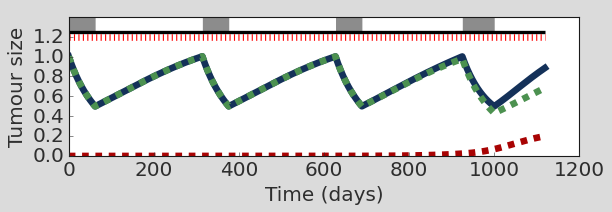

In [26]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

model = ExponentialModel(method='RK45', dt = 1)
model.SetParams(**expParamDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=2000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= expParamDic['N0']
model.resultsDf = model.resultsDf[model.resultsDf.R < 0.8 * expParamDic['Kr']]

print(f"Mean TTP under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

plt.xlabel('Time (days)'); plt.ylabel('Tumour size'); plt.tight_layout() 
plt.savefig("../figures/exponential_model_example.pdf")

## Critical Threshold ($\alpha = 1$)

In [27]:
def calc_critical_threshold(tau, Ks, N0, rS, **_args):
    denominator = ((Ks / ( 1.2 * N0)) - 1) * np.exp(rS * tau) + 1
    return Ks / denominator


In [28]:
print(f"Critical threshold size is {calc_critical_threshold(100, **expParamDic):.2f}")

Critical threshold size is 0.92


Mean TTP under Adaptive Therapy is 1045 days


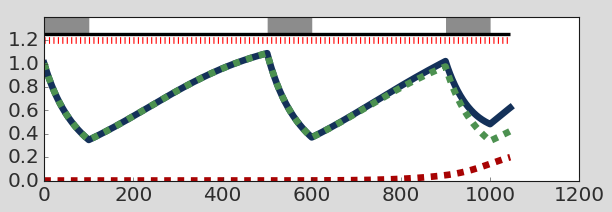

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

model = ExponentialModel(method='RK45', dt = 1)
model.SetParams(**expParamDic)
model.Simulate_AT(atThreshold=0.9, intervalLength=100, t_end=2000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= expParamDic['N0']
model.resultsDf = model.resultsDf[model.resultsDf.R < 0.8 * expParamDic['Kr']]

print(f"Mean TTP under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

# plt.savefig("../figures/exo_model_example.pdf")

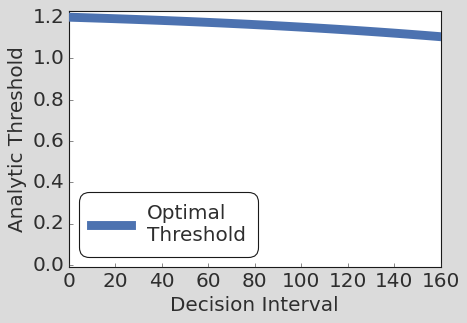

In [30]:
plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(1,1,figsize=(6,4))

tau_values = np.linspace(0, 160, 100)
n_stars = [calc_critical_threshold(tau=t,**expParamDic)/expParamDic['N0'] for t in tau_values]
ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, label = 'Optimal\nThreshold'); 

# val = calc_critical_treatment_interval(n_crit = 0.5 * n0,**odeParamDic) 
# ax.hlines(xmin=0, xmax=max(tau_values), y=0.5, linestyles="--", linewidth=6, color=colors['AT'])
# ax.vlines(ymin=0, ymax=0.5, x=val, linestyles="--", linewidth=6, color=colors['AT'], label='AT50 Threshold')

ax.set_ylim(-0.01,1.23); ax.tick_params(right = False, top = False)
plt.gca().legend(loc=3, fontsize=18, numpoints=1, borderaxespad=0.7).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel("Decision Interval"); plt.ylabel("Analytic Threshold");

In [31]:
def calc_ttp(params, n_crit, interval):
    arg = n_crit
    model = ExponentialModel(dt=1); model.SetParams(**params)
    model.Simulate_AT(atThreshold=arg, atMethod='Threshold',
                    intervalLength=interval, t_end=4000, refSize = params['N0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
    model.resultsDf = model.resultsDf[model.resultsDf.R < 0.8 * params['Kr']]
    return model.resultsDf.Time.max()

In [ ]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

# make these smaller to increase the resolution
dx, dy = 1, 0.01
dx, dy = 2, 0.02

# generate 2 2d grids for the x & y bounds
crit_n_grid, tau_grid = np.mgrid[slice(0.6, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]

vectorized_calc_ttp = np.vectorize(calc_ttp)
ttp_values = vectorized_calc_ttp(
    params = expParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('viridis'), norm=None)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold'); 

ax.set_xlim(0, np.max(tau_grid)); 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/exponential_model_threshold_a1.pdf"); plt.show()

Next step is probably to change a parameter value to make this curve stepper so we can consider more variation with the time interval. That may need faster rebound off treatment (i.e. a smaller original tumor or faster growth rate?)

Mean TTP under Adaptive Therapy is 696 days


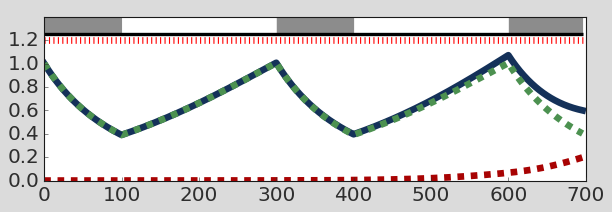

In [32]:
expParamDic = {'rS': 0.00715, 'rR': 0.023, 'Ks': 1, 'Kr': 0.25, 'dDs': 2, 'dDr': 0, 
               'S0': 0.5, 'R0':2.5e-5, 'DMax':1, 'alpha':1, 'gamma':0.0021, 'N0': 0.5+2.5e-5}

fig, ax = plt.subplots(1,1,figsize=(8,3))
model = ExponentialModel(method='RK45', dt = 1); model.SetParams(**expParamDic)
model.Simulate_AT(atThreshold=0.9, intervalLength=100, t_end=2000)
model.Trim(dt=1); model.resultsDf[['TumourSize', 'S', 'R']] /= expParamDic['N0']
model.resultsDf = model.resultsDf[model.resultsDf.R < 0.8 * expParamDic['Kr']]

print(f"Mean TTP under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

# plt.savefig("../figures/exo_model_example.pdf")

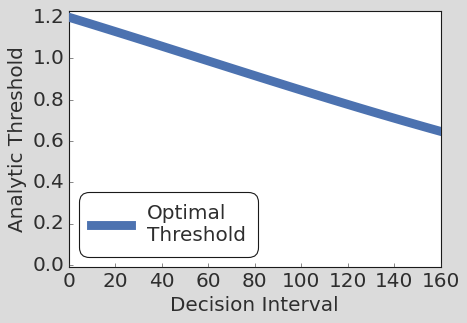

In [33]:
plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(1,1,figsize=(6,4))

tau_values = np.linspace(0, 160, 100)
n_stars = [calc_critical_threshold(tau=t,**expParamDic)/expParamDic['N0'] for t in tau_values]
ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, label = 'Optimal\nThreshold'); 

# val = calc_critical_treatment_interval(n_crit = 0.5 * n0,**odeParamDic) 
# ax.hlines(xmin=0, xmax=max(tau_values), y=0.5, linestyles="--", linewidth=6, color=colors['AT'])
# ax.vlines(ymin=0, ymax=0.5, x=val, linestyles="--", linewidth=6, color=colors['AT'], label='AT50 Threshold')

ax.set_ylim(-0.01,1.23); ax.tick_params(right = False, top = False)
plt.gca().legend(loc=3, fontsize=18, numpoints=1, borderaxespad=0.7).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel("Decision Interval"); plt.ylabel("Analytic Threshold");

In [ ]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

# make these smaller to increase the resolution
# dx, dy = 1, 0.01
dx, dy = 2, 0.02

# generate 2 2d grids for the x & y bounds
crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]

vectorized_calc_ttp = np.vectorize(calc_ttp)
ttp_values = vectorized_calc_ttp(
    params = expParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold'); 

ax.set_xlim(0, np.max(tau_grid)); 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/exponential_model_threshold_a1_new.pdf"); plt.show()

## Critical Threshold ($\alpha \neq 1$)

In [34]:
def calc_critical_threshold_general(tau, Ks, N0, rS, alpha, **_args):
    inner_bracket = (Ks / (1.2 * N0))**alpha - 1
    outer_bracket = (inner_bracket * np.exp(alpha * rS * tau)) + 1
    return Ks * outer_bracket**(-1/alpha)

In [35]:
expParamDic_low = expParamDic.copy(); expParamDic_low['alpha'] = 0.5
expParamDic_high = expParamDic.copy(); expParamDic_high['alpha'] = 2

In [96]:
plt.rcParams['font.size'] = '18'

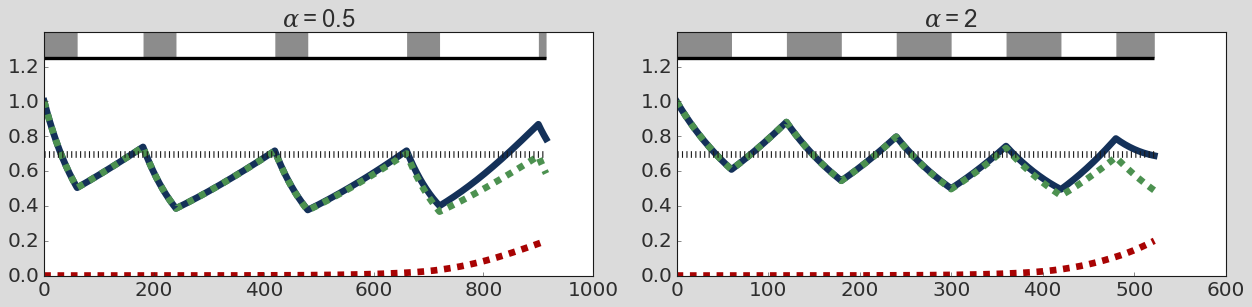

In [97]:

fig, ax = plt.subplots(1,2,figsize=(16,4))

for i, params in enumerate([expParamDic_low, expParamDic_high]):
    model = ExponentialModel(method='RK45', dt = 1); model.SetParams(**params)
    model.Simulate_AT(atThreshold=0.7, intervalLength=60, t_end=2000, atMethod='Threshold')
    # model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=2000, atMethod='Zhang')
    model.Trim(dt=1); model.resultsDf[['TumourSize', 'S', 'R']] /= params['N0']
    model.resultsDf = model.resultsDf[model.resultsDf.R < 0.8 * params['Kr']]

    palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
    PlotSimulation(model.resultsDf, ax=ax[i], legend=False, colors = palette, linewidth = 6,
                   prog_line = False)
    ax[i].hlines(y=0.7, xmin=0, xmax=max(model.resultsDf.Time), linestyles=":", linewidth=6, color='k')

    
ax[0].set_title(r'$\alpha = 0.5$')
ax[1].set_title(r'$\alpha = 2$')

plt.savefig("../figures/exo_model_example.pdf")

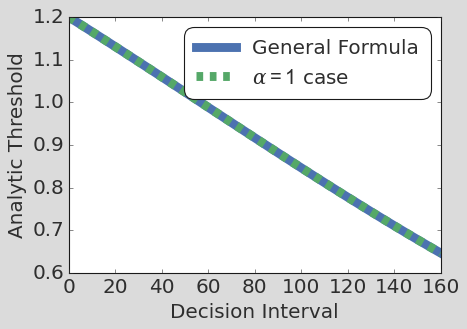

In [37]:
# First check that the alpha = 1 line agrees with before

plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(1,1,figsize=(6,4))


n_stars_new = [calc_critical_threshold_general(tau=t,**expParamDic)/expParamDic['N0'] for t in tau_values]
ax.plot(tau_values, n_stars_new, linewidth = 8, linestyle='-', label = 'General Formula'); 
ax.plot(tau_values, n_stars, linewidth = 8, linestyle='--', label = r'$\alpha = 1$ case'); 

# ax.set_ylim(-0.01,1.23); ax.tick_params(right = False, top = False)
plt.gca().legend(fontsize=18, numpoints=1, borderaxespad=0.7).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel("Decision Interval"); plt.ylabel("Analytic Threshold");

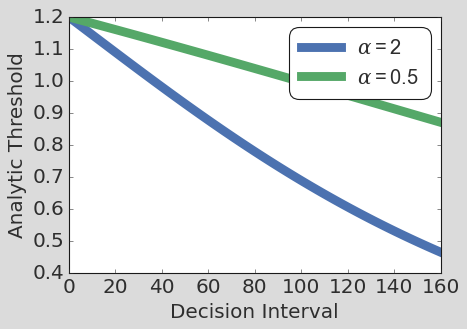

In [38]:
# Then plot both of these critical treatment lines.

plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(1,1,figsize=(6,4))

n_stars_high = [calc_critical_threshold_general(tau=t,**expParamDic_high)/expParamDic['N0'] for t in tau_values]
n_stars_low = [calc_critical_threshold_general(tau=t,**expParamDic_low)/expParamDic['N0'] for t in tau_values]
ax.plot(tau_values, n_stars_high, linewidth = 8,  label = r'$\alpha = 2$'); 
ax.plot(tau_values, n_stars_low, linewidth = 8,  label = r'$\alpha = 0.5$'); 

# ax.set_ylim(-0.01,1.23); ax.tick_params(right = False, top = False)
plt.gca().legend(fontsize=18, numpoints=1, borderaxespad=0.7).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel("Decision Interval"); plt.ylabel("Analytic Threshold");

In [ ]:
# Once we are happy with the parameters above, lets plot some meshes

dx, dy = 1, 0.01
# dx, dy = 2, 0.02

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]

vectorized_calc_ttp = np.vectorize(calc_ttp)

# Calculate TTP values for low alpha
ttp_values_low = vectorized_calc_ttp(
    params = expParamDic_low, n_crit = crit_n_grid,
    interval = tau_grid
)
ttp_values_low = ttp_values_low[:-1, :-1]

# Calculate TTP values for high alpha
ttp_values_high = vectorized_calc_ttp(
    params = expParamDic_high, n_crit = crit_n_grid,
    interval = tau_grid
)
ttp_values_high = ttp_values_high[:-1, :-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

im1 = ax1.pcolormesh(tau_grid, crit_n_grid, ttp_values_low, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im1, ax=ax1)
ax1.plot(tau_values, n_stars_low, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold')
ax1.set_xlim(0, np.max(tau_grid))
ax1.set_xticks(ax1.get_xticks()[::2])
ax1.set_title(r'$\alpha = 0.5$')

im2 = ax2.pcolormesh(tau_grid, crit_n_grid, ttp_values_high, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im2, ax=ax2)
ax2.plot(tau_values, n_stars_high, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold')
ax2.set_xlim(0, np.max(tau_grid))
ax2.set_xticks(ax2.get_xticks()[::2])
ax2.set_title(r'$\alpha = 2$')

fig.tight_layout()
plt.savefig("../figures/exponential_model_threshold_comparison_alpha_panel.pdf")
plt.show()

In [43]:
def calc_offset_ttp(params, n_crit, interval, offset):
    arg = n_crit
    model = ExponentialModel(dt=1); model.SetParams(**params)

    # Simulate offset
    initial_drug = n_crit < 1
    model.Simulate([[0, offset, initial_drug]])

    if model.resultsDf.TumourSize.iloc[-1] > 1.2 * params['N0']:
        model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
        return model.resultsDf.Time.max()
    else:
        new_params = params.copy()
        new_params['S0'] = model.resultsDf.S.iloc[-1]
        new_params['R0'] = model.resultsDf.R.iloc[-1]

        model2 = LotkaVolterraModel(dt=1); model2.SetParams(**new_params)
        rescaled_prog = 1.2 * params['N0'] / model.resultsDf.TumourSize.iloc[-1]
        model2.Simulate_AT(atThreshold=arg, atMethod='Threshold',
                           intervalLength=interval, t_end=4000, 
                           refSize = params['N0'], tumourSizeWhenProgressed=rescaled_prog)
        model2.resultsDf = model2.resultsDf[model2.resultsDf.TumourSize < 1.2 * params['N0']]
        model2.resultsDf = model2.resultsDf[model2.resultsDf.R < 0.8 * params['Kr']]
        return model2.resultsDf.Time.max() + offset

def calc_ttp_repeats(params, n_crit, interval, output_func=np.mean):  
    N = 5
    N_reps = min(N, interval)
    ttp_values = np.zeros(int(N_reps))

    if interval < N:
        offset_vals = np.arange(0, interval)
    else:
        offset_vals = np.linspace(0, interval, N)
    
    for i, offset in enumerate(offset_vals):
        ttp_values[i] = calc_offset_ttp(params, n_crit, interval, offset)
    return output_func(ttp_values)


In [ ]:
# Once we are happy with the parameters above, lets plot some meshes

dx, dy = 1, 0.01
# dx, dy = 10, 0.1

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]

calc_ttp_repeats_min = lambda params, n_crit, interval: calc_ttp_repeats(params, n_crit, interval, output_func=np.min)
vectorized_calc_ttp = np.vectorize(calc_ttp_repeats_min)

# Calculate TTP values for low alpha
ttp_values_low = vectorized_calc_ttp(
    params = expParamDic_low, n_crit = crit_n_grid,
    interval = tau_grid
)
ttp_values_low = ttp_values_low[:-1, :-1]

# Calculate TTP values for high alpha
ttp_values_high = vectorized_calc_ttp(
    params = expParamDic_high, n_crit = crit_n_grid,
    interval = tau_grid
)
ttp_values_high = ttp_values_high[:-1, :-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

im1 = ax1.pcolormesh(tau_grid, crit_n_grid, ttp_values_low, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im1, ax=ax1)
ax1.plot(tau_values, n_stars_low, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold')
ax1.set_xlim(0, np.max(tau_grid))
ax1.set_xticks(ax1.get_xticks()[::2])
ax1.set_title(r'$\alpha = 0.5$')

im2 = ax2.pcolormesh(tau_grid, crit_n_grid, ttp_values_high, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im2, ax=ax2)
ax2.plot(tau_values, n_stars_high, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold')
ax2.set_xlim(0, np.max(tau_grid))
ax2.set_xticks(ax2.get_xticks()[::2])
ax2.set_title(r'$\alpha = 2$')

fig.tight_layout()
plt.savefig("../figures/exponential_model_threshold_comparison_alpha_panel_min.pdf")
plt.show()

In [ ]:
# Once we are happy with the parameters above, lets plot some meshes

dx, dy = 1, 0.01
# dx, dy = 10, 0.1

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]

vectorized_calc_ttp = np.vectorize(calc_ttp_repeats)

# Calculate TTP values for low alpha
ttp_values_low = vectorized_calc_ttp(
    params = expParamDic_low, n_crit = crit_n_grid,
    interval = tau_grid
)
ttp_values_low = ttp_values_low[:-1, :-1]

# Calculate TTP values for high alpha
ttp_values_high = vectorized_calc_ttp(
    params = expParamDic_high, n_crit = crit_n_grid,
    interval = tau_grid
)
ttp_values_high = ttp_values_high[:-1, :-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

im1 = ax1.pcolormesh(tau_grid, crit_n_grid, ttp_values_low, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im1, ax=ax1)
ax1.plot(tau_values, n_stars_low, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold')
ax1.set_xlim(0, np.max(tau_grid))
ax1.set_xticks(ax1.get_xticks()[::2])
ax1.set_title(r'$\alpha = 0.5$')

im2 = ax2.pcolormesh(tau_grid, crit_n_grid, ttp_values_high, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im2, ax=ax2)
ax2.plot(tau_values, n_stars_high, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold')
ax2.set_xlim(0, np.max(tau_grid))
ax2.set_xticks(ax2.get_xticks()[::2])
ax2.set_title(r'$\alpha = 2$')

fig.tight_layout()
plt.savefig("../figures/exponential_model_threshold_comparison_alpha_panel_mean.pdf")
plt.show()